# 
In summer 1996, I was fortunate enough as a graduate student to be asked to assist the British Geological Survey in its monitoring of the Soufriere Hills Volcano, Montserrat. Within minutes of landing on the island, I was whisked up in a helicopter, sitting next to a doorway, with dodgy seatbeats secured with strips of duct tape, as we flew over a steaming lava dome with pyroclastic flows running down its sides, and people leaning over me to get a better view and take photographs, as the helicopter tilted first one way, then another. Did I mention there were no doors? That was quite an introduction. And it was a whos-who of British volcanology, with a few French, Canadian, and American volcanologists too. At the University of Leeds, behind my Sun workstation doing my modelling work, I had read all these papers by Sparks, Aspinall, Wadge, Francis, Oppenheimer, McGuire, and Kilburn, and now I was working alongside them, and drinking rum punches. My role was to lead the Operations Room and the seismic monitoring, providing continuous 2-way radio communications with field parties working in dangerous locations. Every morning and evening we'd provide press releases, summarizing the latest visual and seismic observations, and 3 times a week the Governor and Chief Minister would visit the fledging observatory, and we'd have open, passionate debates about what was going to happen next.

It occurred to me then, we could provide better warnings to field teams by attempting to locate pyroclastic flows in near-real-time, using seismic amplitude data. I imagined a screen with a map of the volcano in the Operations Rooms, and as the helicorder pens would begin oscillating, the trajectories of a pyroclastic flow would begin to show up on the map, and we could leap on the radio and warn field crews.

For a proof of concept, I tried this with 1-minute RSAM data, as we will now do.

## To do
-
- Add a simulation routine where i pick a lat,lon, and generate synthetic trace data across a network and then see if it locates correctly,
- try different misfit functions
- try different frequency ranges (try 8 Hz?)
- find faster algorithms (look at literature)
- add the shrinking grid, e.g. just have 2 (or 3) iterations with the 2nd grid dropping from 100 m node spacing to 11 m node spacing (then maybe to 2 m?)
- add a threshold level to represent noise, don't locate below that level

In [7]:
import os
import sys
import pygmt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import obspy
from obspy.geodetics import locations2degrees, degrees2kilometers
from obspy import read_inventory
sys.path.append('../lib')
import setup_paths
paths = setup_paths.paths
from SAM import VSAM, VSEM, DSAM

def montserrat_topo_map(finish=False, zoom_level=1, inv=None):
    #define etopo data file
    # topo_data = 'path_to_local_data_file'
    #topo_data = '@earth_relief_30s' #30 arc second global relief (SRTM15+V2.1 @ 1.0 km)
    # topo_data = '@earth_relief_15s' #15 arc second global relief (SRTM15+V2.1)
    topo_data = '@earth_relief_03s' #3 arc second global relief (SRTM3S)
    
    # define plot geographical range
    if zoom_level==1:
        minlon, maxlon = -62.25, -62.13
        minlat, maxlat = 16.66, 16.83
    elif zoom_level==2:
        minlon, maxlon = -62.21, -62.15
        minlat, maxlat = 16.66, 16.74    
    # Visualization
    fig = pygmt.Figure()
    
    # make color pallets
    pygmt.makecpt(
        cmap='topo',
        series='-1300/1300/100',
        continuous=True
    )
    
    # plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=[minlon, maxlon, minlat, maxlat],
        projection='M4i',
        shading=True,
        frame=True
        )
    
    # plot continents, shorelines, rivers, and borders
    fig.coast(
        region=[minlon, maxlon, minlat, maxlat],
        projection='M4i',
        shorelines=True,
        frame=True
        )
    
    # plot the topographic contour lines
    fig.grdcontour(
        grid=topo_data,
        interval=100,
        annotation="100+f6p",
        limit="-1300/1300", #to only display it below 
        pen="a0.15p"
        )
    
    # Plot colorbar
    fig.colorbar(
        frame='+l"Topography"',
    #     position="x11.5c/6.6c+w6c+jTC+v" #for vertical colorbar
        )
    
    if inv:
    
    # save figure
    if finish:
        save_fig = 0
        if not save_fig:
            fig.show() 
            #fig.show(method='external') #open with the default pdf reader
        else:
            fig.savefig("topo-plot.png", crop=True, dpi=300, transparent=True)
        #     fig.savefig("topo-plot.pdf", crop=True, dpi=720)
            print('Figure saved!')
    return fig

class Grid:
    def __init__(self, centerlat, centerlon, nlat, nlon, node_spacing_m):
        deg2m = 111100
        node_spacing_lat = node_spacing_m / deg2m
        minlat = centerlat - (nlat-1)/2 * node_spacing_lat
        maxlat = centerlat + (nlat-1)/2 * node_spacing_lat
        latrange = np.array([lat for lat in np.arange(minlat, maxlat, node_spacing_lat)])
        node_spacing_lon = node_spacing_lat / np.cos(centerlat / (2 * math.pi))
        minlon = centerlon - (nlon-1)/2 * node_spacing_lon
        maxlon = centerlon + (nlon+1)/2 * node_spacing_lon
        lonrange = np.array([lon for lon in np.arange(minlon, maxlon, node_spacing_lon)])
        gridlon, gridlat = np.meshgrid(lonrange, latrange)
        self.gridlon = gridlon
        self.gridlat = gridlat
        self.node_spacing_lat = node_spacing_lat
        self.node_spacing_lon = node_spacing_lon
        self.lonrange = lonrange
        self.latrange = latrange

    def plot(self, node_spacing_m):
        fig = montserrat_topo_map()
        #plt.plot(self.gridlon, self.gridlat, marker='+', color='k', linestyle='none')
        #plt.show()
        symsize = node_spacing_m/9000
        stylestr = f'+{symsize}c'
        
        fig.plot(x=self.gridlon.reshape(-1), y=self.gridlat.reshape(-1), style=stylestr, pen='black')
        fig.show()

import random
def simulate_vsam(source, inv, Amax=0.000250, sampling_interval=10):
    a = random.uniform(0, 1, size=(10,1)) * Amax
    seed_ids = InventoryTools.inventory2traceid(inv)
    st = obspy.Stream()
    for id in seed_ids:
        coordinates[id] = self.inventory.get_coordinates(id)
        distance = locations2degrees(coordinates[tr.id]['latitude'], coordinates[tr.id]['longitude'], \
                                     source['latitude'], source['longitude'])
        tr = obspy.Trace()
        tr.id = id
        tr.stats.starttime = obspy.UTCDateTime(2024,1,1)
        tr.stats.delta = sampling_interval
        tr.data = a * distance
        st.append(tr)
    samobject = VSAM(stream=st, sampling_interval=sampling_interval)

    return samobject

class ASL:
    def __init__(self, samobject, metric, inventory, gridobj):
        ''' 
        ASL: Simple amplitude-based source location for volcano-seismic data 
        This program takes a VSAM, VSEM, or DSAM object as input
        Then armed with an inventory that provides station coordinates, it attempts
        to find a location for each sample by reducing amplitudes based on the grid
        node to station distance. Grid nodes are contained in a Grid object.

        ASL can use any one of the mean, max, median, VLP, LP, or VT metrics from a VSAM or DSAM object,
        or the energy metric from a VSEM object.

        '''

        if isinstance(samobject, VSAM) or isinstance(samobject, DSAM):
            datatype = 'amplitude'
        elif isinstance(samobject, VSEM):
            datatype = 'energy'
        else:
            print('invalid type passed as samobject. Aborting')
            return

        self.samobject = samobject
        self.metric = metric
        self.inventory = inventory
        self.gridobj = gridobj
        self.node_distances_km = {}
        self.station_coordinates = {}
        self.amplitude_corrections = {}

    def setup(self, surfaceWaves=False):  
        self.compute_grid_distances()
        self.compute_amplitude_corrections(surfaceWaves = surfaceWaves)
        
def inventory2seedids(inv, chancode='', force_location_code='*'):
    seed_ids = list()

    for networkObject in inv:
        if chancode:
            networkObject = networkObject.select(channel=chancode)
        stationObjects = networkObject.stations

        for stationObject in stationObjects:
            channelObjects = stationObject.channels
            for channelObject in channelObjects:
                this_seed_id = networkObject.code + '.' + stationObject.code + f'.{force_location_code}.' \
                            + channelObject.code
                seed_ids.append(this_seed_id)
    
    return seed_ids
        
def get_station_coordinates(inv):
    seed_ids = inventory2seedids(inv)
    for seed_id in seed_ids:
        coordinates[seed_id] = inv.get_coordinates(seed_id)
        

    def compute_grid_distances(self):
        st = self.samobject.to_stream()
        coordinates = {}
        node_distances_km = {}
        for tr in st:
            d_list = []
            try:
                coordinates[tr.id] = self.inventory.get_coordinates(tr.id)
                stalat = coordinates[tr.id]['latitude']
                stalon = coordinates[tr.id]['longitude']
                #print(tr.id, stalat, stalon)
            except Exception as e:
                #print(e)
                continue
            gridlat = self.gridobj.gridlat.reshape(-1)
            gridlon = self.gridobj.gridlon.reshape(-1)
            nodelatlon = zip(gridlat, gridlon)
            distances = np.array([locations2degrees(nodelat, nodelon, stalat, stalon) for nodelat, nodelon in nodelatlon])       
            node_distances_km[tr.id] = np.array([degrees2kilometers(thisdistance) for thisdistance in distances])
        self.node_distances_km = node_distances_km
        self.station_coordinates = coordinates 
        
    @staticmethod
    def set_peakf(metric, df):
        if metric in ['mean', 'median', 'max', 'rms', 'energy']:
            ratio = df['VT'].sum()/df['LP'].sum()
            peakf = np.sqrt(ratio) * 4
        elif metric == 'VLP':
            peakf = 0.1
        elif metric == 'LP':
            peakf = 2.0
        elif metric == 'VT':
            peakf = 8.0
        return peakf
        
        
    def compute_amplitude_corrections(self, surfaceWaves=False, wavespeed_kms=None, Q=None, fix_peakf=None):
        #st = self.samobject.to_stream()
        corrections = {}
        if not wavespeed_kms:
            if surfaceWaves:
                wavespeed_kms = 1.5
            else:
                wavespeed_kms = 3.0
        for seed_id, df in self.samobject.dataframes.items():
            if fix_peakf:
                peakf = fix_peakf
            else:
                peakf = self.set_peakf(self.metric, df)
            wavelength_km = peakf * wavespeed_kms
            if surfaceWaves and seed_id[-2]=='H':
                gsc = np.sqrt(np.multiply(self.node_distances_km[seed_id], wavelength_km))
            else:
                gsc = self.node_distances_km[seed_id]
            #print(seed_id, gsc)
            if Q:
                t = np.divide(self.node_distances_km[seed_id], wavespeed_kms)
                iac = np.power(math.e, math.pi * peakf * t / Q)
                corrections[seed_id] = np.multiply(gsc, iac)
            else:
                corrections[seed_id] = gsc
            #print(corrections[seed_id])
        self.amplitude_corrections = corrections
            
            

    
    def locate(self):
        gridlat = self.gridobj.gridlat.reshape(-1)
        gridlon = self.gridobj.gridlon.reshape(-1)
        st = self.samobject.to_stream(metric=self.metric)
        seed_ids = [tr.id for tr in st]
        lendata = len(st[0].data)
        #print(seed_ids[0])
        #print(self.amplitude_corrections)
        corrections = self.amplitude_corrections[seed_ids[0]]
        #print(len(corrections))
        #print(self.amplitude_corrections[seed_ids[0]])
        locations = []
        best_corrections = {}
        source_amplitudes = []
        #t = [t.datetime for t in st[0].times('utcdatetime')]
        t = st[0].times('utcdatetime')
        for i in range(lendata): # loop ovder time samples
            y = [tr.data[i] for tr in st] # (len(st), 1)
            reduced_y = []
            misfit = []
            best_j = -1
            best_misfit = 1e15

            #####################################################################
            ##### how to vectorize this loop to compute misfit for each node? ###
            
            for j in range(len(corrections)): # loop over nodes
                # assume source is at grid node j
                c = [self.amplitude_corrections[id][j] for id in seed_ids] # corrections for this node (len(st), 1)
                if self.metric=='energy':
                    c = np.multiply(c,c)
                #print(c)
                reduced_y = np.multiply(y, c) # correcting everything to 1 km distance for all seed ids
                this_misfit = np.nanstd(reduced_y)/np.nanmedian(reduced_y)
             #####################################################################
                
                #print(this_misfit)
                if this_misfit < best_misfit:
                    best_misfit = this_misfit
                    best_j = j
                
            for tracenum, id in enumerate(seed_ids):
                A = y[tracenum] * self.amplitude_corrections[id][best_j]
            best_A = np.nanmedian(A)
            misfit.append(best_misfit)
            locations.append( ( t[i], gridlat[best_j], gridlon[best_j], best_A )  )
            
        return locations
        # Here is where i would add loop over shrinking grid

    
    def locate2(self):
        gridlat = self.gridobj.gridlat.reshape(-1)
        gridlon = self.gridobj.gridlon.reshape(-1)
        st = self.samobject.to_stream(metric=self.metric)
        seed_ids = [tr.id for tr in st]

        t = st[0].times('utcdatetime')

        source_DRE = np.empty(len(t), dtype=float)
        source_lat = np.empty(len(t), dtype=float)
        source_lon = np.empty(len(t), dtype=float)
        for i in range(len(t)): # loop ovder time samples
            DRE_stations_nodes = np.empty(  ( len(st), len(gridlat) ) )
            for j, seed_id in enumerate(seed_ids):
                tr = st.select(id=seed_id)[0]
                DRE_stations_nodes[j] = np.multiply(self.amplitude_corrections[seed_id], tr.data[i])
            #print('shape of all array = ',DRE_stations_nodes.shape)
            DRE_mean_nodes = np.nanmean(DRE_stations_nodes, axis=0)
            DRE_std_nodes = np.nanstd(DRE_stations_nodes, axis=0)
            #print('shape of mean array = ',DRE_mean_nodes.shape)
            misfit = np.divide(DRE_std_nodes, DRE_mean_nodes)
            #print('shape of misfit array = ',misfit.shape)
            lowest_misfit = np.nanmin(misfit)
            lowest_misfit_index = np.argmin(misfit)
            source_DRE[i] = DRE_mean_nodes[lowest_misfit_index]
            source_lat[i] = gridlat[lowest_misfit_index]
            source_lon[i] = gridlon[lowest_misfit_index]
            
        source = {'t':t, 'lat':source_lat, 'lon':source_lon, 'DR':source_DRE}
        return source

    def plot2(self, source=None, cross_scale=1e3, zoom_level=1, threshold_amp=None):
        fig = montserrat_topo_map(zoom_level=zoom_level)
        stalat = [self.station_coordinates[seed_id]['latitude'] for seed_id in self.station_coordinates]
        stalon = [self.station_coordinates[seed_id]['longitude'] for seed_id in self.station_coordinates]
        #fig.plot(x=lon, y=lat, style="c0.3c", fill="white", pen="black")
        fig.plot(x=stalon, y=stalat, style="s0.3c", fill="black")
        
        if source:
            # map of crosses sized to DR
            lat = source['lat']
            lon = source['lon']
            t = source['t']
            t_dt = [this_t.datetime for this_t in t]
            amp = source['DR']
            if threshold_amp:
                indices = amp<threshold_amp
                amp[indices]=0
                lat[indices]=None
                lon[indices]=None
            #print(amp)
            symsize = amp*cross_scale
            #print(symsize)
            fig.plot(x=lon, y=lat, size=symsize, style="x", fill='white', pen='black')
            fig.show()

            # heatmap. somehow need a histogram
            df = pd.DataFrame()
            df['time'] = t
            df['lon'] = lon
            df['lat'] = lat
            df['DR'] = amp
            unique_locationsDF = df[['lat', 'lon']].value_counts().reset_index(name='count')
            fig2 = montserrat_topo_map(zoom_level=zoom_level)
            print(unique_locationsDF)
            x=unique_locationsDF['lon'].to_numpy()
            y=unique_locationsDF['lat'].to_numpy()
            symsize = unique_locationsDF['count'].to_numpy()/100.0
            #fig2.plot(x=x, y=y, style='c0.3c', fill='black', pen='black')
            fig2.plot(x=x, y=y, size=symsize, style='cc', fill='black', pen='2p,black')
            fig2.show()

            # timeseries of DR above threshold_amp
            tr = obspy.Trace()
            tr.stats.starttime = t[0]
            tr.stats.delta = t[1]-t[0]
            tr.data = amp
            tr.plot();

            # time-longitude plot
            plt.figure()
            plt.scatter(t_dt, lon, s=amp*cross_scale, marker='x')  

            # time-latitude plot
            plt.figure()
            plt.scatter(t_dt, lat, s=amp*cross_scale, marker='x')
            
        else: # no location data
            fig.show()


METRIC:  VT


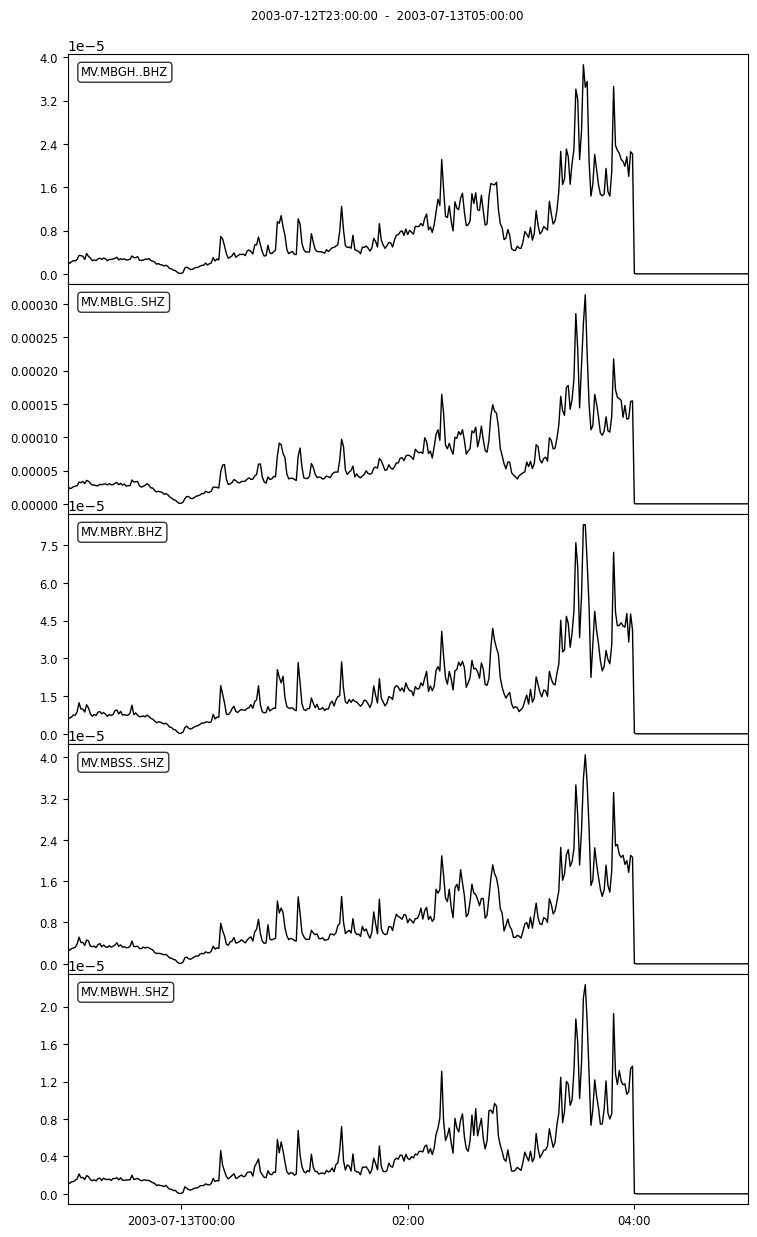

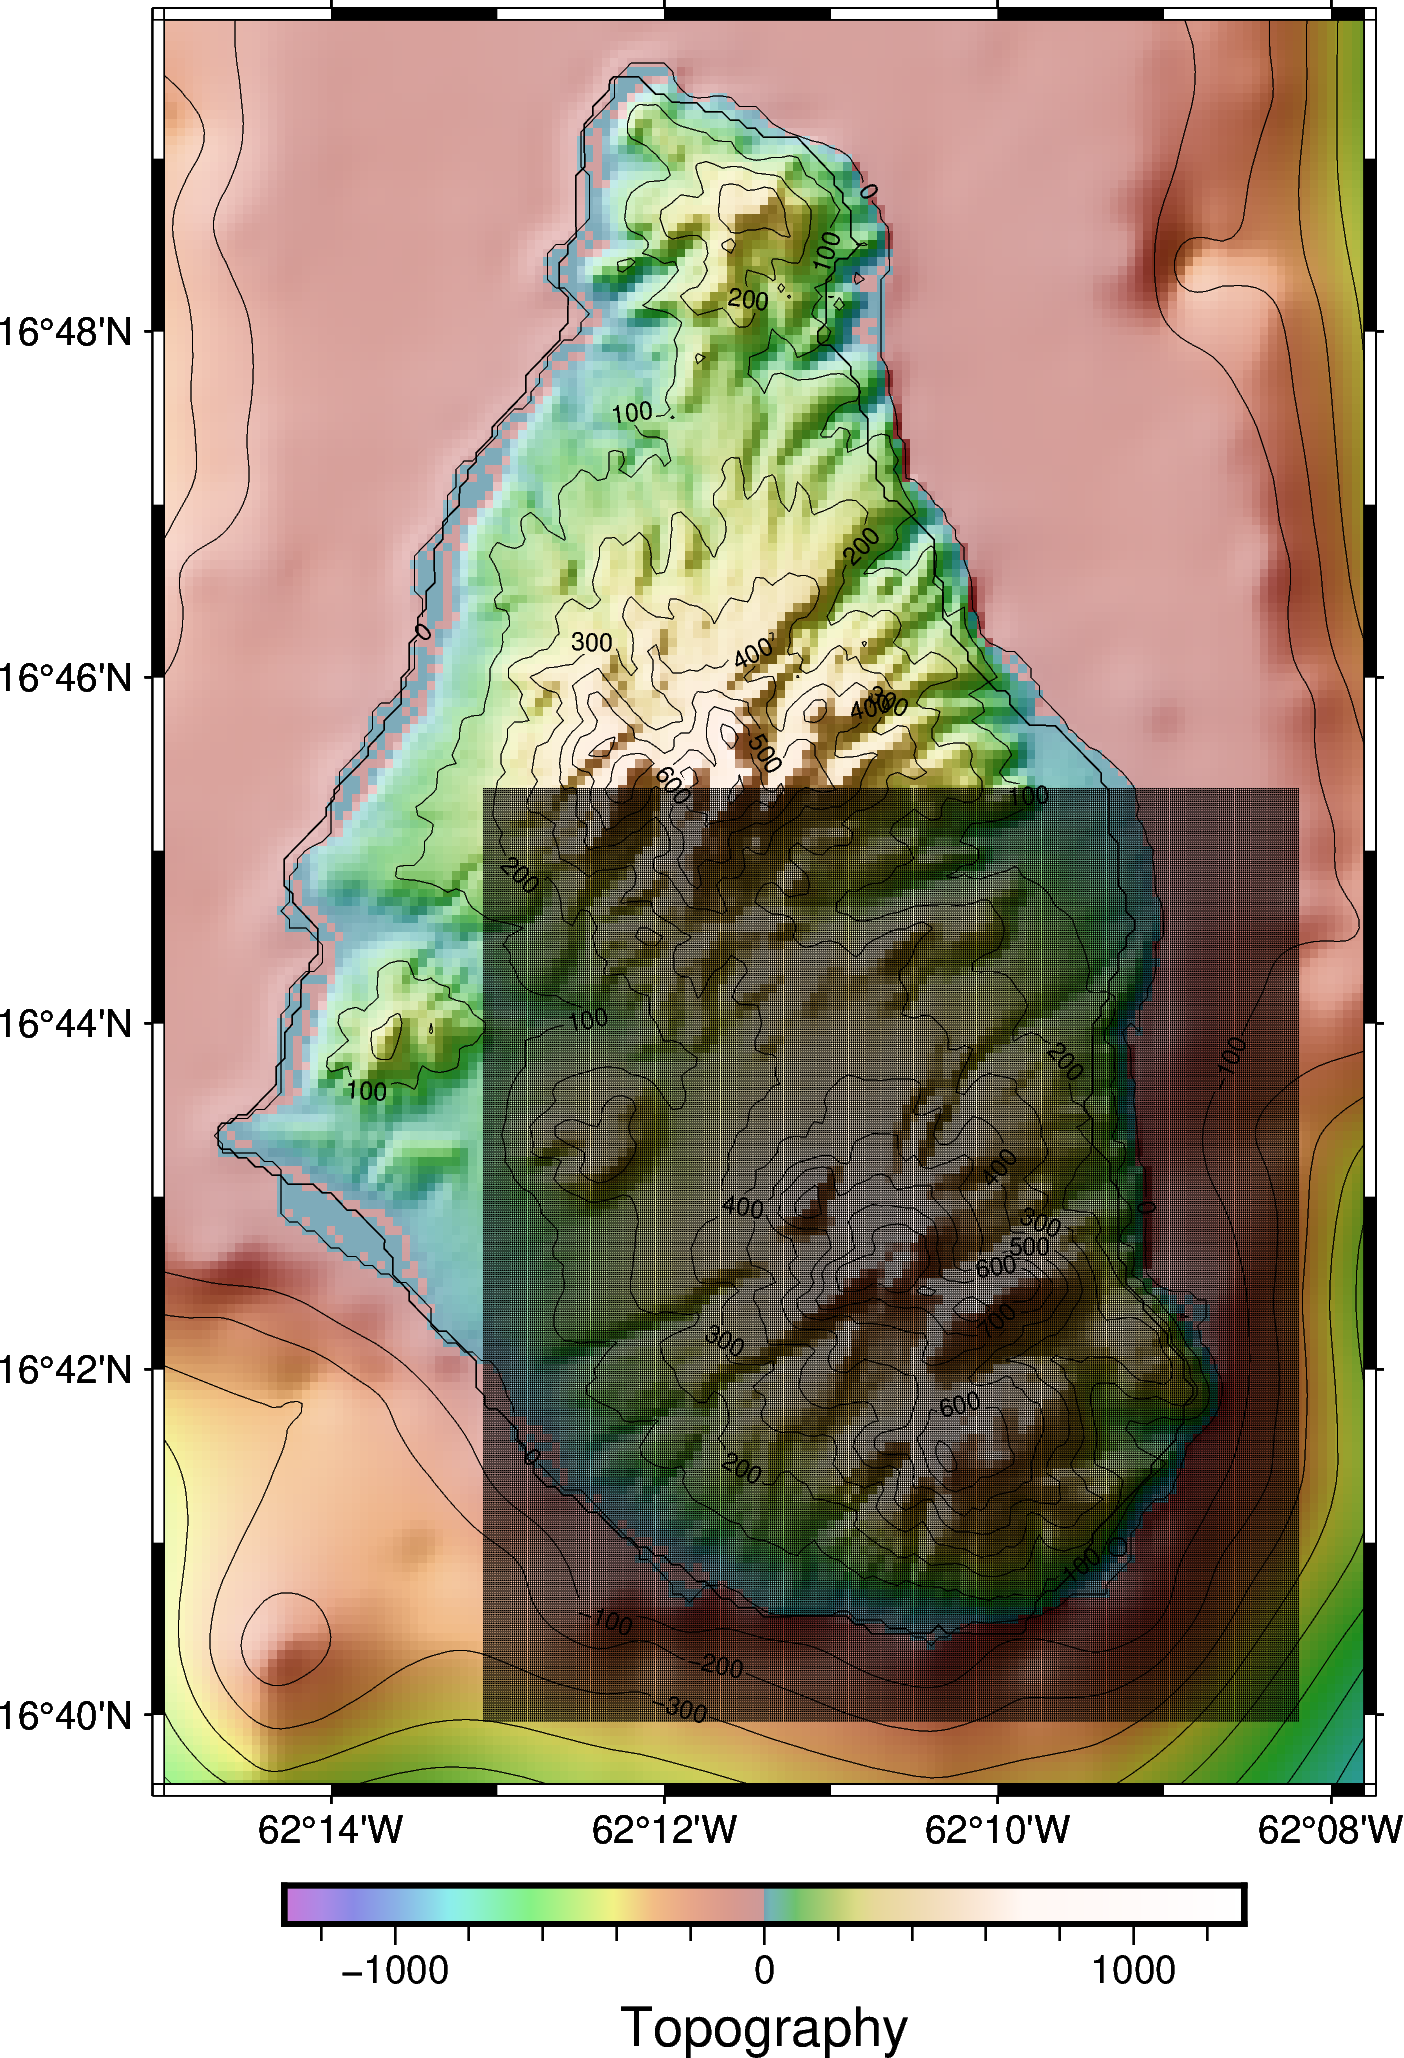

In [8]:
import time
time1 = time.time()

source = {'lat':16.71111, 'lon':-62.17722}
node_spacing_m = 20
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
gridobj.plot(node_spacing_m = node_spacing_m)

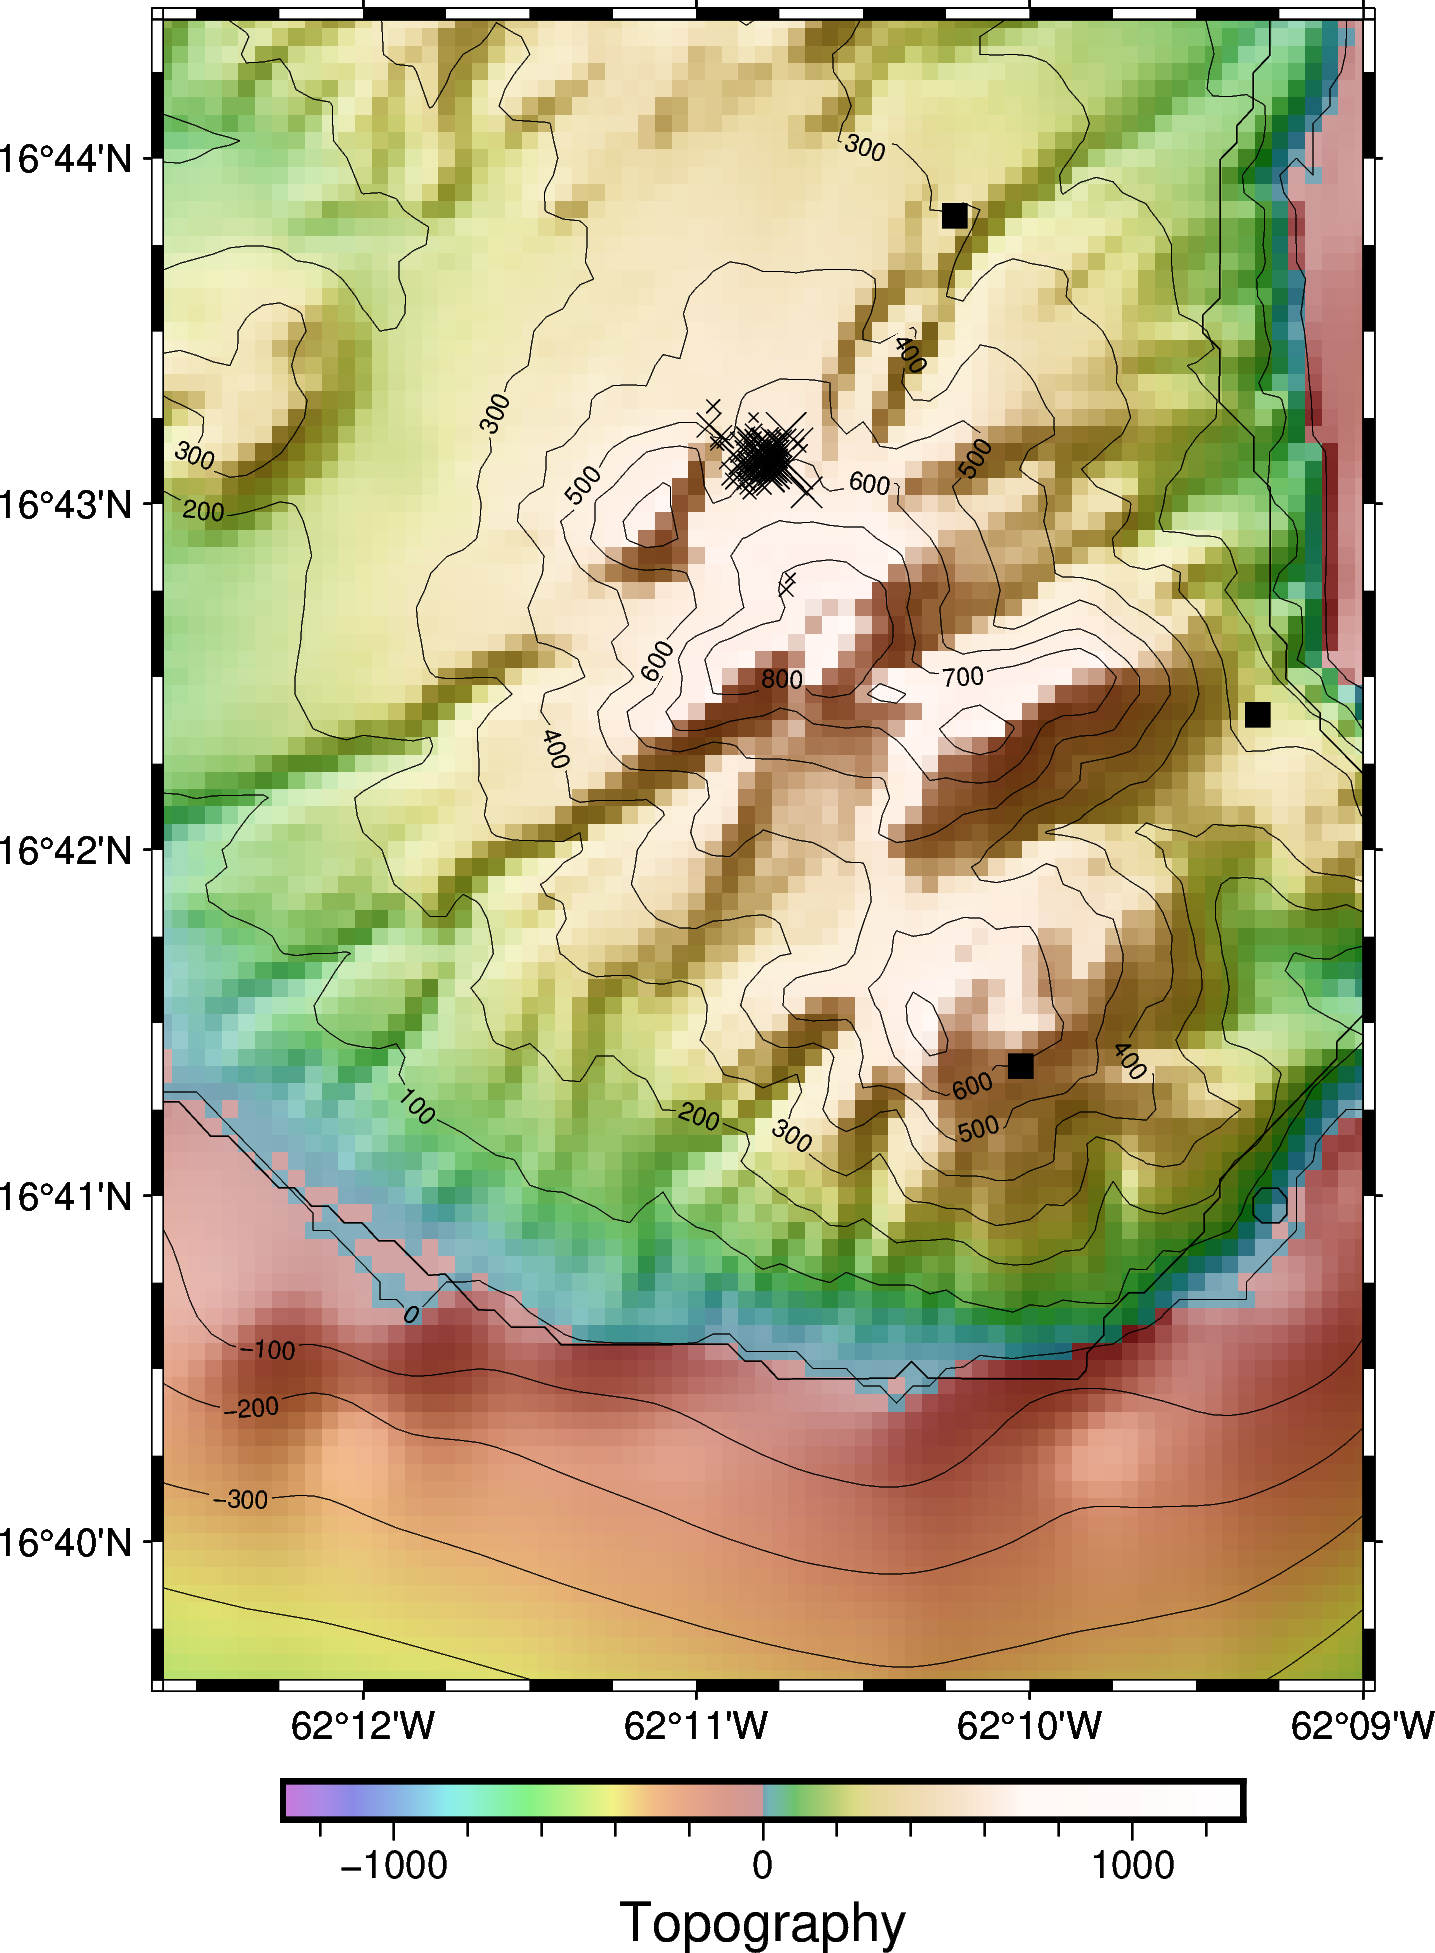

          lat        lon  count
0   16.718311 -62.179658      5
1   16.718491 -62.179455      4
2   16.718311 -62.180674      4
3   16.719211 -62.179252      4
4   16.719031 -62.179455      4
..        ...        ...    ...
80  16.720111 -62.180471      1
81  16.720111 -62.178845      1
82  16.720471 -62.182705      1
83  16.720831 -62.180471      1
84  16.717231 -62.177829      1

[85 rows x 3 columns]


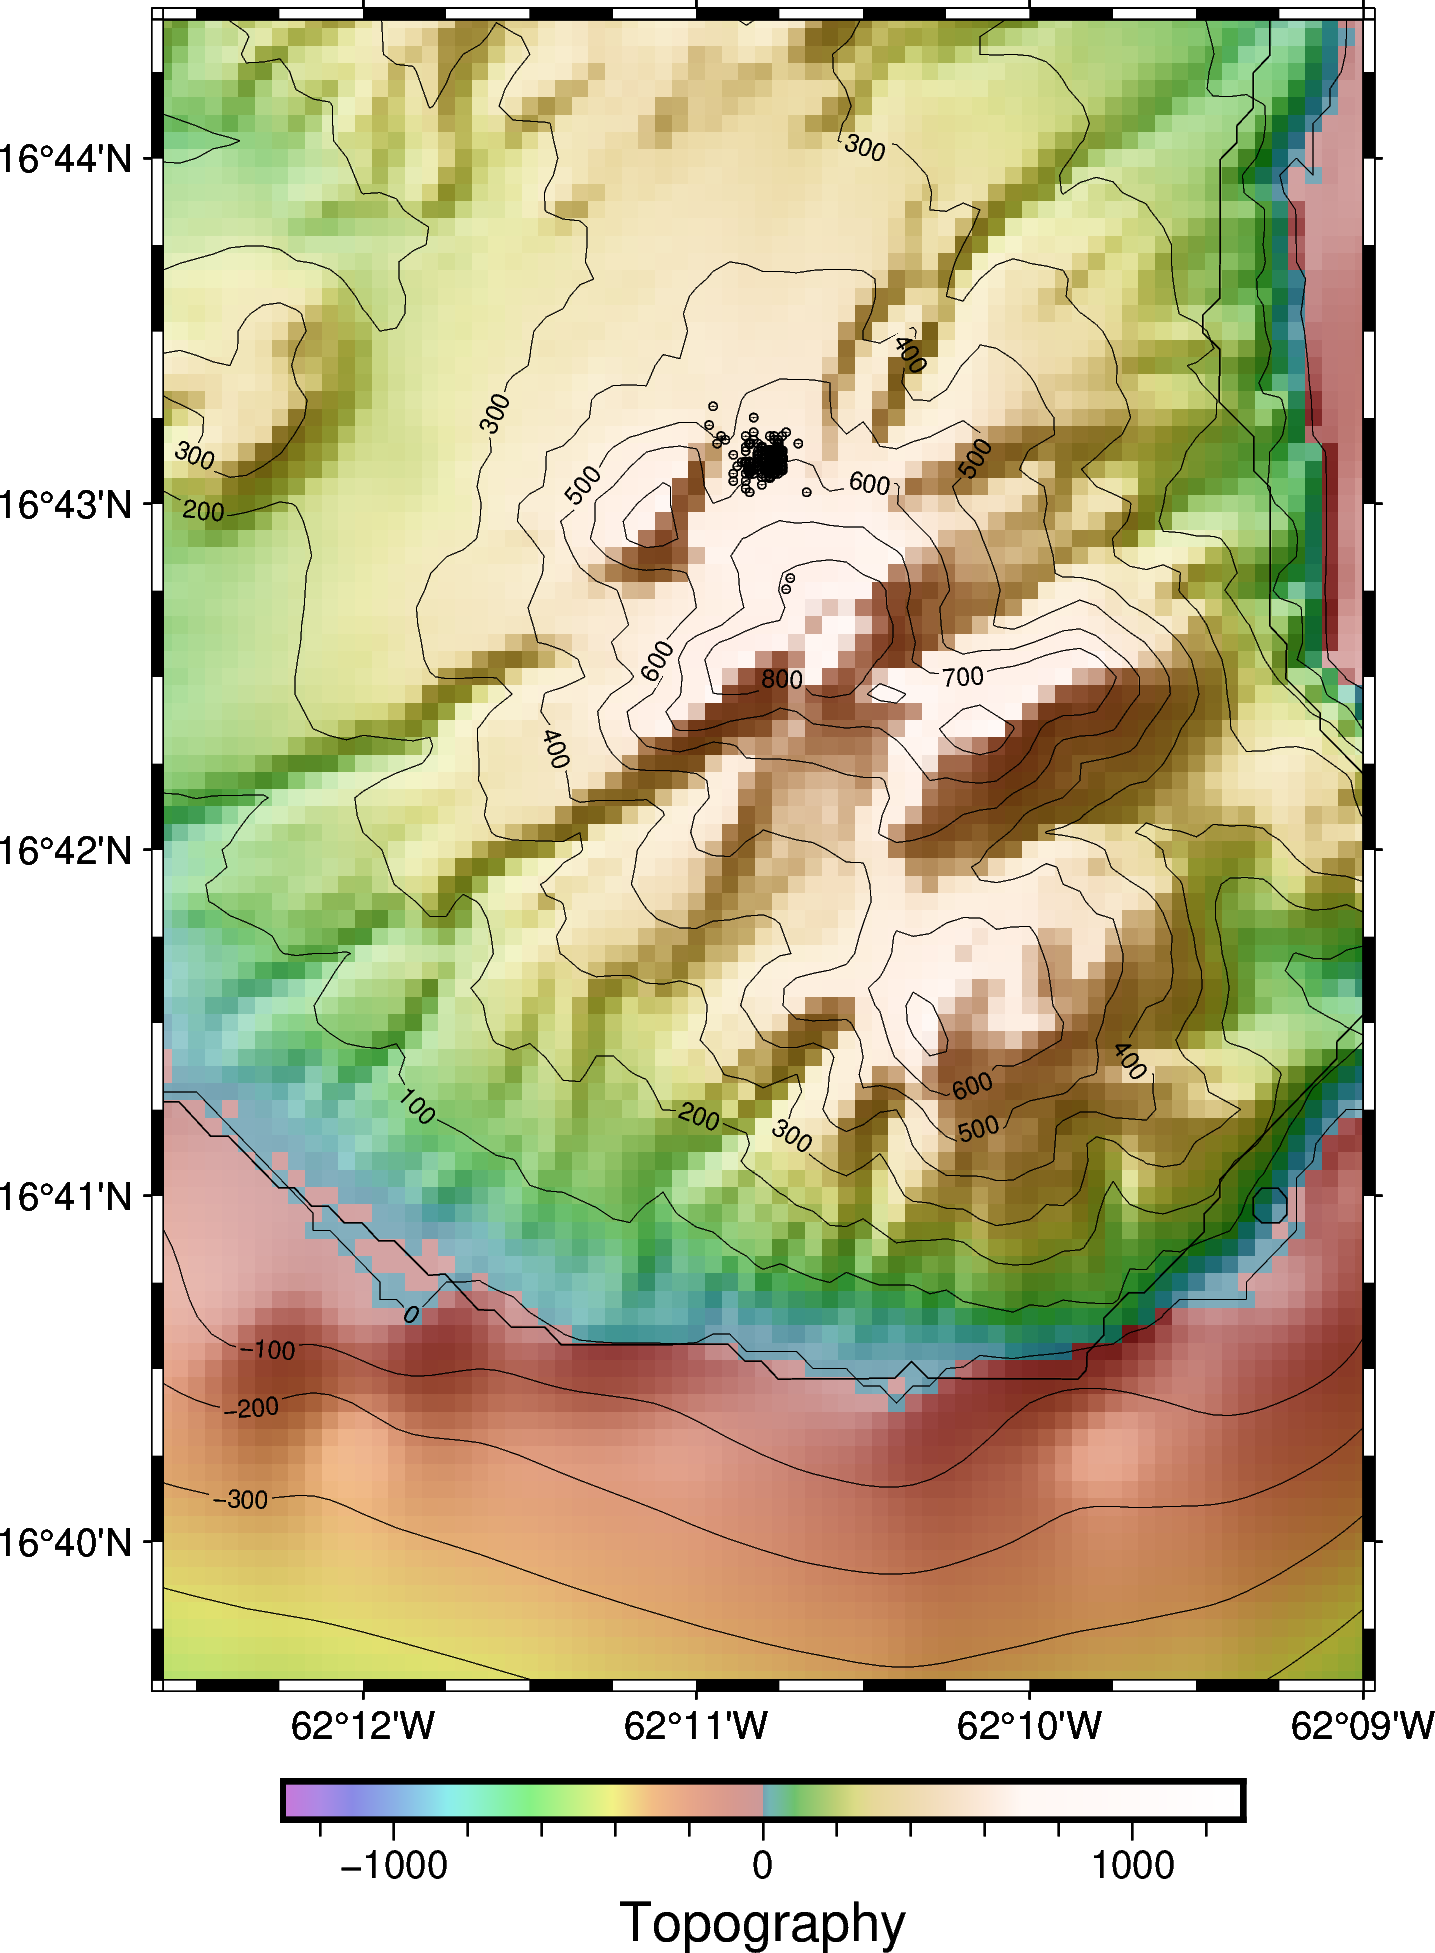

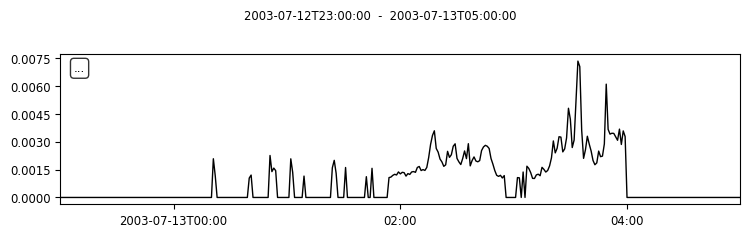

[5.41210175e-05 2.05923688e+01 3.41050625e-02 6.58976698e+00
 6.21860409e+00]


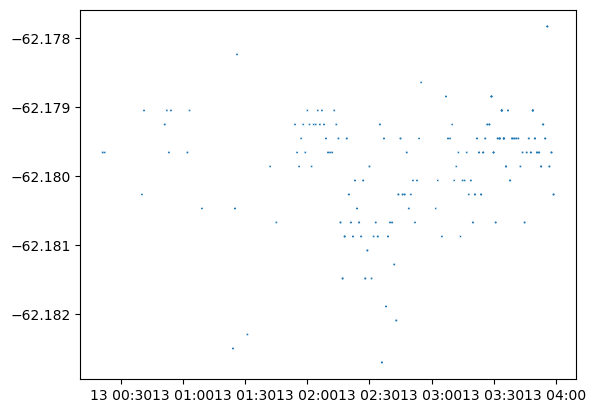

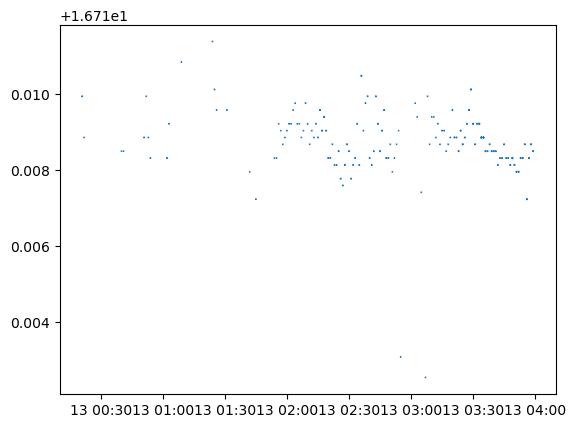

In [9]:
invMVO = read_inventory(os.path.join(paths['RESPONSE_DIR'],'MV.xml'), format='stationxml')
#invMVO.plot(projection='local', resolution='f');
startt2 = obspy.UTCDateTime(2003,7,12,23,0,0)
endt2 = obspy.UTCDateTime(2003,7,13,5,0,0)
vsamObj2 = VSAM.read(startt2, endt2, SAM_DIR=paths['SAM_DIR'], sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'])    
vsamObj2.plot(metrics='VT')
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0
times = []
times.append(time.time())
aslobj = ASL(vsamObj2, 'rms', invMVO, gridobj)
times.append(time.time())
aslobj.compute_grid_distances()
times.append(time.time())
aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf = peakf)
times.append(time.time())
source = aslobj.locate2()
times.append(time.time())
aslobj.plot2(source, cross_scale=1e2, zoom_level=2, threshold_amp=0.001)
times.append(time.time())
print(np.diff(times))

In [ ]:
# do a simulation test here

In [ ]:
print(np.diff(times))
